# Importing Modules

In [2]:
!pip install pyspark
!pip install mysql.connector

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=ade8904a0671e3facfcdece83c78b73f93a103e5e35343784d629e11c7a95780
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mysql.connector: filename=mysql_connector-2.2.9-cp310-cp310-linux_x86_64.whl size=247953 sha256=8edc28394799d51c0457faec4da54cea240822251d68e43852e3140b801ae413
  Stored in directory: /root/.cache/pip/wheels/76/48/9b/da67ff1a18fe8e9d428f9b1a177

In [3]:
import tweepy
import datetime
import mysql.connector

import pandas as pd
from pyspark.sql import SparkSession

# Initializing Database

In [ ]:
# MySQL database credentials
db_host = "localhost"
db_user = "root"
db_password = "talit123"
db_name = "bigdata"

# Connect to MySQL database
db = mysql.connector.connect(
    host=db_host,
    user=db_user,
    password=db_password,
    database=db_name
)

# Create a cursor object to execute SQL queries
cursor = db.cursor()

# Function to create the tweets table if it doesn't exist
def create_table():
    try:
        cursor.execute("""
            CREATE TABLE tweets (
                id BIGINT PRIMARY KEY,
                tweet_text TEXT,
                tweet_date DATETIME,
                location VARCHAR(255)
            )
        """)
        db.commit()
    except mysql.connector.Error as err:
        print("Error creating table:", err)

# Function to store tweet data in the database
def store_tweet(tweet):
    tweet_id = tweet.id
    tweet_text = tweet.full_text
    tweet_date = tweet.created_at
    location = tweet.user.location
    
    query = "INSERT INTO tweets (id, tweet_text, tweet_date, location) VALUES (%s, %s, %s, %s)"
    values = (tweet_id, tweet_text, tweet_date, location)
    
    try:
        cursor.execute(query, values)
        db.commit()
    except mysql.connector.Error as err:
        print("Error storing tweet:", err)
        
# Function to remove all tweets from the table
def remove_all_tweets():
    try:
        cursor.execute("DELETE FROM tweets")
        db.commit()
        print("All tweets removed successfully.")
    except mysql.connector.Error as err:
        print("Error removing tweets:", err)

# Extracting Tweets

In [ ]:
# remove_all_tweets()

All tweets removed successfully.


In [ ]:
# Twitter API credentials
consumer_key = "cvzXuYfTY5pRBPo0Jljimx"
consumer_secret = "lhYuckV4iJW5aJHC5J2bTZSAsIFe6YyHmnwTUVIgu"
access_token = "1207775187036416-42qNml07kScG9GDet8oxuwgm"
access_token_secret = "KX2yZqYTcIGDndzBc0aXpL4jg6ArhQmlml7WbW"

# Authenticate with Twitter API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

# Function to extract tweets about AI and Machine Learning
def extract_tweets(query="Artificial Intelligence", total_tweets=10000000):
    tweet_count = 0
    try:
        for tweet in tweepy.Cursor(api.search_tweets, q=query, lang="en", tweet_mode="extended").items():
            store_tweet(tweet)
            tweet_count += 1
            
            if tweet_count % 100 == 0:
                print(f"Stored {tweet_count} tweets...")
                
            # Adjust the number of tweets to extract based on your requirements
            if tweet_count >= total_tweets:
                break
    except tweepy.TweepError as e:
        print("Error extracting tweets:", e)

In [ ]:
extract_tweets()

# Loading Data into Hadoop (Pyspark)

In [ ]:
# SQL query to fetch all rows from the tweets table
query = "SELECT * FROM tweets"

# Execute the query
cursor.execute(query)

# Fetch all the rows from the query result
rows = cursor.fetchall()

# Create a pandas DataFrame from the fetched rows
df = pd.DataFrame(rows, columns=["id", "tweet_text", "tweet_date", "location"])

# Specify the file path for the output XLSX file
output_file_path = "tweets.xlsx"

# Save the DataFrame as an XLSX file
df.to_excel(output_file_path, index=False)

print("Tweets table downloaded as XLSX successfully.")

In [4]:
# Create a SparkSession
spark = SparkSession.builder.appName("TweetsAnalysis").getOrCreate()

# Read the XLSX dataset file into a Pandas DataFrame
pandas_df = pd.read_excel("tweets.xlsx")

# Convert the Pandas DataFrame to a PySpark DataFrame
df = spark.createDataFrame(pandas_df)

# Show the top 10 records
df.show(10)

+-------------------+--------------------+-------------------+--------------------+
|                 id|          tweet_text|         tweet_date|            location|
+-------------------+--------------------+-------------------+--------------------+
|1660424517305487104|@WandileMngomez3 ...|2023-05-21 23:17:08|Outlook, Saskatch...|
|1660424614730771968|RT @antgrasso: Co...|2023-05-21 23:17:32|       United States|
|1660424625820691968|RT @ArchDaily: Ho...|2023-05-21 23:17:34|      Nagasaki.Japan|
|1660424676236218112|Nhs heart experts...|2023-05-21 23:17:46|                 NaN|
|1660424851688133120|Sen. Blumenthal u...|2023-05-21 23:18:28|                🇦🇺|
|1660424984081101056|RT @UncannyMagazi...|2023-05-21 23:19:00|      Wisconsin, USA|
|1660425149110439936|RT @60Minutes: Cy...|2023-05-21 23:19:39|                 NaN|
|1660425188742417920|RT @CharlesCasill...|2023-05-21 23:19:48|        埼玉県蓮田市|
|1660425257335881984|RT @ArchDaily: Ho...|2023-05-21 23:20:05|    Toronto, Ontario|


In [7]:
from pyspark.sql.functions import udf, split
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.feature import StopWordsRemover
import re

# Define a user-defined function (UDF) to clean the tweet text
def clean_tweet_text(text):
    # Remove special characters, digits, and hashtags
    cleaned_text = re.sub('[^a-zA-Z]', ' ', text)
    cleaned_text = re.sub(r'#\w+', '', cleaned_text)

    # Remove URLs
    cleaned_text = re.sub(r'http\S+', '', cleaned_text)

    # Convert text to lowercase
    cleaned_text = cleaned_text.lower()

    return cleaned_text

# Register the UDF
clean_tweet_udf = udf(clean_tweet_text, StringType())

# Apply the UDF to clean the tweet text
df = df.withColumn('cleaned_text', clean_tweet_udf(df['tweet_text']))

# Split the cleaned tweet text into an array of words
split_text_udf = udf(lambda text: text.split(), ArrayType(StringType()))
df = df.withColumn('cleaned_text_array', split_text_udf(df['cleaned_text']))

# Create a StopWordsRemover instance to remove stopwords
stopwords_remover = StopWordsRemover(inputCol='cleaned_text_array', outputCol='cleaned_text_no_stopwords')

# Remove stopwords from the cleaned tweet text
df = stopwords_remover.transform(df)

# Remove the 'cleaned_text_array' column
df = df.drop('cleaned_text_array')

# Show the cleaned dataset
df.show(10)

+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------------+
|                 id|          tweet_text|         tweet_date|            location|        cleaned_text|  cleaned_text_array|cleaned_text_no_stopwords|
+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------------+
|1660424517305487104|@WandileMngomez3 ...|2023-05-21 23:17:08|Outlook, Saskatch...| wandilemngomez  ...|[wandilemngomez, ...|     [wandilemngomez, ...|
|1660424614730771968|RT @antgrasso: Co...|2023-05-21 23:17:32|       United States|rt  antgrasso  co...|[rt, antgrasso, c...|     [rt, antgrasso, c...|
|1660424625820691968|RT @ArchDaily: Ho...|2023-05-21 23:17:34|      Nagasaki.Japan|rt  archdaily  ho...|[rt, archdaily, h...|     [rt, archdaily, a...|
|1660424676236218112|Nhs heart experts...|2023-05-21 23:17:46|                 NaN|nhs h

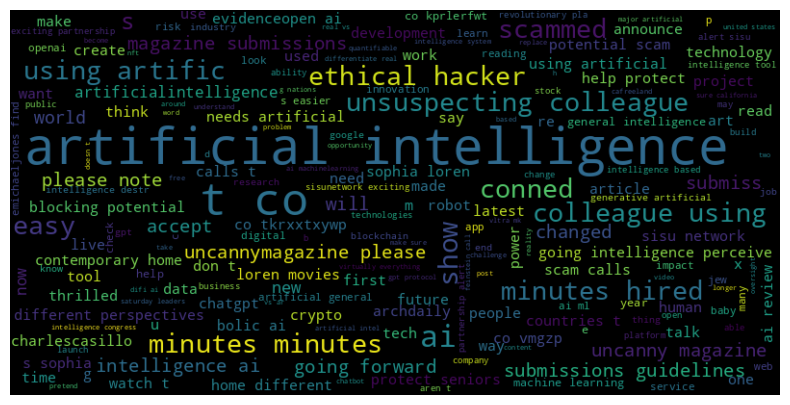

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Set stopwords
stopwords = set(STOPWORDS)
stopwords.update(["amp", "rt", "via"])  # Add additional stopwords if needed

# Combine all the cleaned text into a single string
cleaned_text = " ".join(df.select("cleaned_text").rdd.flatMap(lambda x: x).collect())

# Create a WordCloud object
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="black",
    stopwords=stopwords,
    collocations=True  # Disable collocation detection
).generate(cleaned_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

M

+--------------+
|          word|
+--------------+
|              |
|wandilemngomez|
|       popbase|
|   foreseeable|
|        future|
|   integration|
|    artificial|
|  intelligence|
|       various|
|       domains|
+--------------+
only showing top 10 rows

+------------+-----+
|        word|count|
+------------+-----+
|            | 2418|
|          rt| 1541|
|  artificial| 1482|
|intelligence| 1442|
|          co|  919|
|          ai|  722|
|       using|  376|
|     minutes|  351|
|     ethical|  322|
|        show|  321|
|        easy|  312|
|     scammed|  309|
|      hacker|  309|
|      conned|  308|
|unsuspecting|  308|
+------------+-----+
only showing top 15 rows



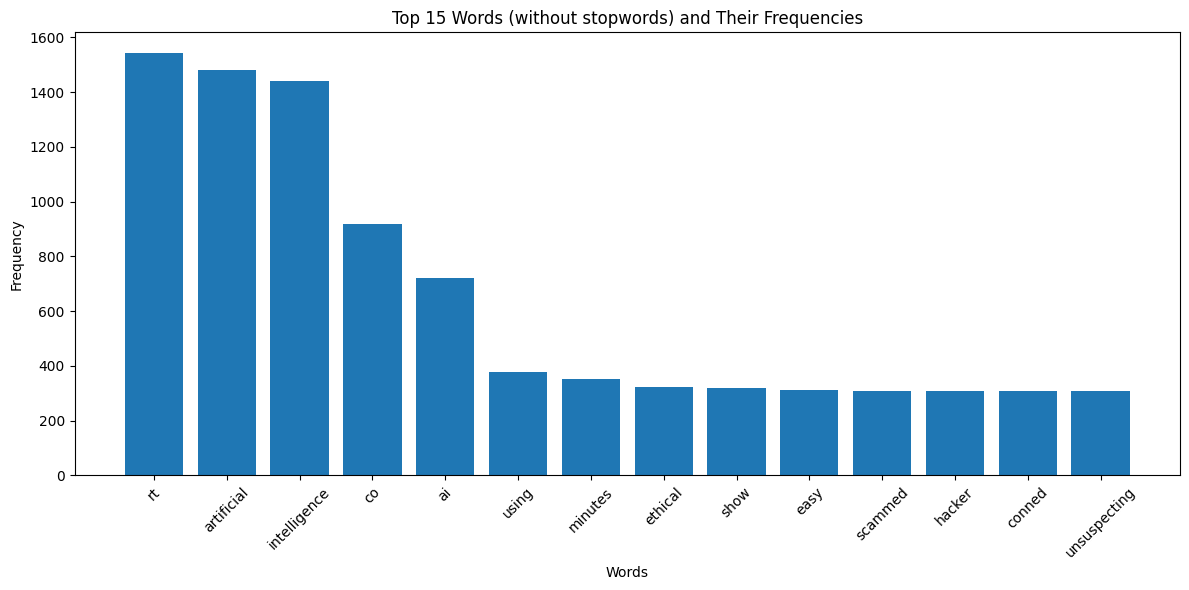

In [18]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import explode, desc, split
import pyspark.sql.functions as F
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.types import ArrayType, StringType
import pandas as pd

# Remove stopwords from the 'cleaned_text' column
stopwords = StopWordsRemover().getStopWords()
df = df.withColumn('cleaned_text_no_stopwords', F.array_except(df['cleaned_text_array'], F.array([F.lit(x) for x in stopwords])))

# Explode the 'cleaned_text_no_stopwords' column to separate each word into a new row
exploded_df = df.select(explode(df['cleaned_text_no_stopwords']).alias('word'))
exploded_df.show(10)

# Calculate the frequency of each word
word_freq_df = exploded_df.groupBy('word').count().orderBy(desc('count'))
word_freq_df.show(15)

# Convert the word frequency DataFrame to a Pandas DataFrame for plotting
word_freq_pd = word_freq_df.limit(15).toPandas().iloc[1:]

# Plot the top 15 words and their frequencies as a bar plot
plt.figure(figsize=(12, 6))
plt.bar(word_freq_pd['word'], word_freq_pd['count'])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 15 Words (without stopwords) and Their Frequencies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [19]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from textblob import TextBlob

# Define a UDF to calculate the polarity of a text using TextBlob
def calculate_polarity(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    return polarity

# Register the UDF
polarity_udf = udf(calculate_polarity, DoubleType())

# Calculate the polarity for each record in the 'cleaned_text' column
df = df.withColumn('polarity', polarity_udf(df['cleaned_text']))

# Show the DataFrame with the new 'polarity' column
df.show(10)


+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------------+--------------------+--------------------+
|                 id|          tweet_text|         tweet_date|            location|        cleaned_text|  cleaned_text_array|cleaned_text_no_stopwords| cleaned_text_string|            polarity|
+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------------+--------------------+--------------------+
|1660424517305487104|@WandileMngomez3 ...|2023-05-21 23:17:08|Outlook, Saskatch...| wandilemngomez  ...|[, wandilemngomez...|     [, wandilemngomez...|[wandilemngomez, ...|-0.04285714285714285|
|1660424614730771968|RT @antgrasso: Co...|2023-05-21 23:17:32|       United States|rt  antgrasso  co...|[rt, , antgrasso,...|     [rt, , antgrasso,...|[rt, antgrasso, c...|                -0.6|
|1660424625820691968|RT @ArchD

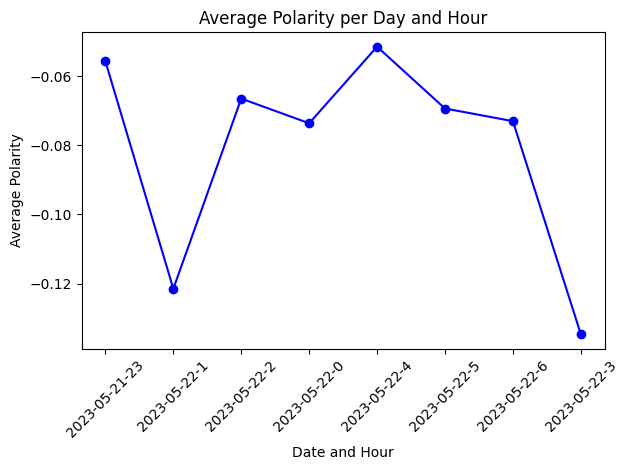

In [26]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyspark.sql.functions import hour, avg, date_format

# Convert the 'tweet_date' column to datetime format
df = df.withColumn('tweet_date', F.to_timestamp(df['tweet_date']))

# Extract the date and hour from the 'tweet_date' column
df = df.withColumn('date', date_format(df['tweet_date'], 'yyyy-MM-dd'))
df = df.withColumn('hour', hour(df['tweet_date']))

# Calculate the average polarity per day and hour
daily_hourly_avg_df = df.groupBy('date', 'hour').agg(avg('polarity').alias('avg_polarity'))

# Convert the resulting DataFrame to Pandas
daily_hourly_avg_pandas = daily_hourly_avg_df.toPandas()

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the average polarity per day and hour
ax.plot(daily_hourly_avg_pandas['date'] + '-' + daily_hourly_avg_pandas['hour'].astype(str),
        daily_hourly_avg_pandas['avg_polarity'], marker='o', linestyle='-', color='b')

# Set the labels and title
ax.set_xlabel('Date and Hour')
ax.set_ylabel('Average Polarity')
ax.set_title('Average Polarity per Day and Hour')

# Rotate the x-axis labels for better readability
ax.xaxis.set_tick_params(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()